# Programing exercise 4: Collective Ising spins

Due on Monday, 19.11.2018, 14.15h

### Total: 100 points

<font color='red'>
This is not a master solution.    
    
There are some small consistencies with the exercises that you had to solve. (e.g. the initial state in exercise 5)
    
Also, it is not necessarily complete, but the essential ingredients for the solution should be there.
</font>

## The problem

The collective Ising spin-model with a transverse field is governed by the Hamiltonian
$$
H=-\frac{J}{N}S_z^2 - \Omega S_x
$$
with the collective spin operators $S_\alpha = \sum_i \sigma_i^\alpha/2$, where $\sigma_i^\alpha$ is a Pauli operator acting on spin $i$. This model features a quantum phase transition at $\Omega/J=1$, meaning that the ground state propoerties change abruptly, and also a dynamical phase transition at the same point, meaning that the long time properties of the dynamics change. The dynamical case was recently studied experimentally using a chain of trapped ions (https://www.nature.com/articles/nature24654). Note the different convention (x<>z) chosen there. Also in the experiment the interactions where not strictly infinite range but powerlaw with a small exponent. 

We want to use this model as a test case for applying different techniques for solving the time dependent Schrödinger equation.

In [1]:
# load standard libraries

import numpy as np   # standard numerics library
import numpy.linalg as LA
import scipy.linalg as sciLA

import matplotlib.pyplot as plt   # for making plots

import time as time

import scipy.sparse as sparse
import scipy.sparse.linalg as sLA

%matplotlib inline

### Exercise 1

We first want to study the low lying eigenstates and observe the quantum pahse transition. Thus, it makes sense to work with sparse matrices.

Generate the Hamiltonian as a sparse matrix. You can proceed similarly to the coupled oscillator problem: Build the matrix representation of the collective spin operator $S_+$ and $S_z$, and then use these to construct any other operators you need, e.g. $S_x=(S_+ + S_-)/2$. For matrix-matrix and matrix-vector multiplication it is intuitive to use the @ operator in python 3, which is a short hand for the dot() function.

Test your implementation for N=20 with small and large values of $\Omega$. What do you expect for Sz and Sx in either limit? 

In [2]:
def buildSx(N):
    Splusvec = np.sqrt((N-np.arange(0,N))*(np.arange(0,N)+1)) 
    Splus = sparse.diags(Splusvec,-1)
    return (Splus + Splus.T)/2

def buildSz(N):
    return sparse.diags(np.arange(N+1)-N/2)

def buildH(N,ome):
    Sx = buildSx(N)
    Sz = buildSz(N)
    return -Sz @ Sz/N - ome*Sx 

def buildSxSym(N):
    Splusvec = np.sqrt((N-np.arange(0,N/2))*(np.arange(0,N/2)+1))
    Splusvec[-1] *= np.sqrt(2)
    Splus = sparse.diags(Splusvec,-1)
    return (Splus + Splus.T)/2

def buildSz2Sym(N): # note that Sz itsself is zero
    return sparse.diags((np.arange(N/2+1)-N/2)**2)

def buildHSym(N,ome):
    Sx = buildSxSym(N)
    Sz2 = buildSz2Sym(N)
    return -Sz2/N - ome*Sx 
    

In [3]:
# testing symmetrized part
N = 10
ome=1
 
HmatSym=buildHSym(N,ome)

print(HmatSym.toarray())


[[-2.5        -1.58113883  0.          0.          0.          0.        ]
 [-1.58113883 -1.6        -2.12132034  0.          0.          0.        ]
 [ 0.         -2.12132034 -0.9        -2.44948974  0.          0.        ]
 [ 0.          0.         -2.44948974 -0.4        -2.64575131  0.        ]
 [ 0.          0.          0.         -2.64575131 -0.1        -3.87298335]
 [ 0.          0.          0.          0.         -3.87298335  0.        ]]


### Exercise 2

Loop over $\Omega$ (from 0 to 2 in small steps) and record the lowest 3 eigenenergies and, for the ground state, the probabilities P(M) to be in state $|M\rangle$. Plot the 3 lowest energy levels and P(M;$\Omega$) (density plot!). At small $\Omega$ you should observe kind of a "spontaneous symmetry breaking": The gap between ground and first excited state becomes very small. The states $|00...0\rangle = |N,N/2\rangle$ and $|11...1\rangle = |N,-N/2\rangle$ are the degenerate ground states at a$\Omega=0$. The Hamiltonian has a $Z_2$ symmetry. It is invariant under flipping of all spins. Thus the eigenstates should also respect this symmetry and be either symmetric or anti-symmetric with respect to spin flips. However, when the gap between the symmetric and anti-symmetric state becomes too small, the numerical diagonalization algorithm just randomly chooses a superposition of the two states, which can as well be $|N,-N/2\rangle$ or $|N,N/2\rangle$, thus breaking the symmetry.

The spin flip symmetry means that, if written in the symmetrized basis, the Hamiltonian will consist of two disconnected blocks, representing the symmetric and anti-symmetric states. This means that the relevant gap we have to look at is the gap between lowest two states of one block. This can be done by just looking at the energy difference between the ground and the second excited state, which should be both symmetric.

[Optional]: One could also fix this by considering the symmetric and anti-symmetric blocks separately. For this you need to implement the Hamiltonian again in the symmetrized basis (or use a basis transformation into the symmatrized basis). This will give a speedup of at least a factor of 2.

In [20]:
# loop over omega to get study the ground state and gap (use unseymmetrized version)
N = 200
dim = N+1
nEvalsComp = 3;

# loop over omega
omevec = np.linspace(0,2,50)

evalsAll = np.zeros((nEvalsComp,len(omevec)))
gsAll = np.zeros((dim,len(omevec)))

for i in range(len(omevec)):
    # build the Hamiltonian
    Hmat =buildH(N,omevec[i])
    # diagonalize
    evals, evecs = sparse.linalg.eigsh(Hmat,k=nEvalsComp,which='SA')
    evalsAll[:,i] = evals
    gsAll[:,i] = evecs[:,0]

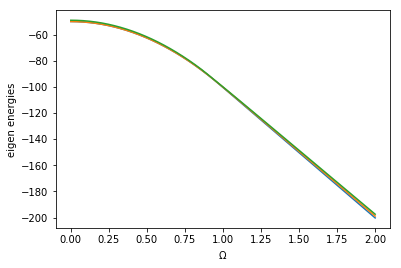

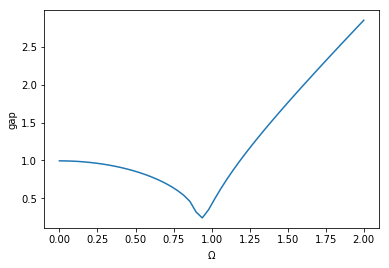

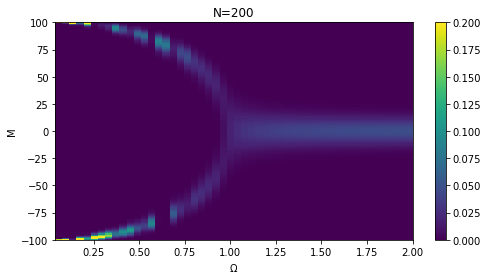

In [21]:
plt.plot(omevec,evalsAll[0])
plt.plot(omevec,evalsAll[1])
plt.plot(omevec,evalsAll[2])
plt.xlabel('$\Omega$')
plt.ylabel('eigen energies')
plt.show()

plt.plot(omevec,evalsAll[2]-evalsAll[0])
plt.xlabel('$\Omega$')
plt.ylabel('gap')
plt.show()

plt.figure(figsize=(8,4))
plt.imshow(np.abs(gsAll)**2,extent=[omevec[1], omevec[-1], -N/2, N/2],clim=(0.0, 0.2),aspect='auto')
plt.colorbar()
plt.xlabel('$\Omega$')
plt.ylabel('M')
plt.title('N='+str(N))
plt.show()

### Exercise 3

Loop over omega and go to large N to see how the gap closes at the critical point. Extract the position and size of the smallest gap as a function of N. Loop N from 40 to 400 in steps of 20. The easiest way to get the minimal gap is to calculate it on an omega-gid around 1, where the transititon is expected to be. I increased $\Omega$ from 0.8 to 1 in 100 steps. You could also make the search for the minimal gap more efficient by some kind of iterative optimization scheme...

Plot the resulting distance of the optimal $\Omega$ from 1 and size of the minimal gap double logarithmically. You should get a power law behavior. Extract the exponent of this power law for both observables.

In [5]:
# loop over omega and N to get study the N-dependence of the gap
nEvalsComp = 3;

Nvec = np.arange(40,410,20)
omevec = np.linspace(0.8,1.0,100)

evalsAll = np.zeros((nEvalsComp,len(omevec),len(Nvec)))
minGap = np.zeros((2,len(Nvec)))


for j in range(len(Nvec)):
    N = Nvec[j]
    print(N)
    dim = N+1
    for i in range(len(omevec)):
        # build the Hamiltonian
        #Hmat = buildH(N,omevec[i])
        Hmat = buildHSym(N,omevec[i])
        # diagonalize
        evals, evecs = sparse.linalg.eigsh(Hmat,k=nEvalsComp,which='SA')
        evalsAll[:,i,j] = evals
    # find position and vlaue of smallest gap
    iOmeMin = np.argmin(evalsAll[1,:,j]-evalsAll[0,:,j])
    minGap[:,j] = [omevec[iOmeMin], evalsAll[1,iOmeMin,j]-evalsAll[0,iOmeMin,j]]

40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400


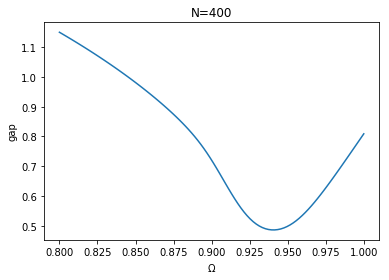

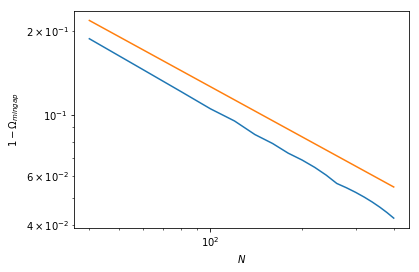

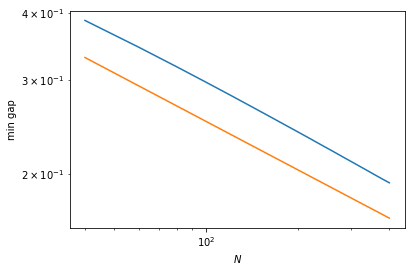

In [8]:
iN=-1;
plt.plot(omevec,evalsAll[2,:,iN]-evalsAll[0,:,iN])
plt.xlabel('$\Omega$')
plt.ylabel('gap')
plt.title('N='+str(Nvec[iN]))
plt.show()
plt.loglog(Nvec,1-minGap[0])
plt.loglog(Nvec,2/Nvec**(0.6))
#plt.plot(Nvec,1-minGapSym[0])
plt.xlabel('$N$')
plt.ylabel('$1-\Omega_{min gap}$')
plt.show()
plt.loglog(Nvec,minGap[1])
plt.loglog(Nvec,1/Nvec**(0.3))
#plt.plot(Nvec,minGapSym[1])
plt.xlabel('$N$')
plt.ylabel('min gap')
plt.show()
#minGapSym=minGap

### Exercise 4 (20 points)

Now calculate the time evolution under the above Hamiltonian, starting in the state $|11...1\rangle = |N,-N/2\rangle$. For this you could use scipy's expm function which allows you to simply exponentiate a matrix so you can directly calculate $exp(-iHt)$ and apply it to the initial state (e.g. using the @ operator). Try this out. You will see that it becomes really slow as you go to larger atom numbers. The more efficient way is to use exact diagonalization. This time the use of sparse matrices is not necessary since we need all the eigenstates anyway. Also, the spin flip symmetry is now not so useful since our initial state already breaks this symmetry. 

To calculate $\psi(t)$, project the initial state onto the eigenstates. Remember that the eigenstates are in the columns of the eigenvector matrix returned by eig (or eigh). Thus the transformation into the energy eigenbasis can be achieved by applying the conjugate transpose of this to the initial state. Evolve the state in the eigenbasis and transform back.

Calculate the expectation values of $S_z$ and $S_z^2$ as a function of time for some value of $\Omega$ below and above 0.5. You should see different behavior in the two regimes. Check whether your reults argee qualitatively with the observations in https://www.nature.com/articles/nature24654 in particular Fig. 2 (the paper is also on the arxiv at https://arxiv.org/abs/1708.01044). Note that their definition of the parameter $\Omega/J$ differs by a factor 1/2 from ours such that the transition point is at 1 for them.

In [47]:
N = 20
dim = N+1 # Hilbert space dimension will be N+1

# build the S+ matrix elements (vector of 1st off-diag)
Splusvec = np.sqrt((N-np.arange(0,N))*(np.arange(0,N)+1)) 
# build the operator as a sparse matrix
Splus = sparse.diags(Splusvec,-1)

# build Sminus by transposing Splus
Sminus = Splus.T

# build collective spin operators
Sx = (Splus + Sminus)/2
Sy = -1j*(Splus - Sminus)/2

# Sz is diagonal with values -N/2, -N/2+1 ... N/2
Sz = sparse.diags(np.arange(N+1)-N/2)

# Square it to get the interaction Hamiltonian
Sz2 = Sz @ Sz

# print(Sz2)
# print(Sminus.toarray())

# build the Hamiltonian
ome = .2
Hmat = -Sz2/N - ome*Sx

# initial state: all in 0
ini = np.eye(1,dim,0)[0]

tvec = np.linspace(0, 10, 101, endpoint = True)

# calculate the time evolution using the matrix exponential
t1=time.time()
observables = 1j*np.zeros((1,len(tvec)))
for i in range(len(tvec)):
    Psit = sciLA.expm(-1j*Hmat.tocsc()*tvec[i]) @ ini
    Szval = Psit.conj().T @ Sz @ Psit
    observables[0,i] = Szval
t2=time.time()
print('time for matrix exponential was '+str(t2-t1))

observables = observables.real 

# calculate the time evolution using exact diagonalization
t1=time.time()

evals, evecs = LA.eigh(Hmat.toarray())

# calculate projections on eigenstates
iniProj = evecs.conj().T @ ini

observables2 = 1j*np.zeros((1,len(tvec)))
for i in range(len(tvec)):
    Psit = evecs @ (np.exp(-1j*evals*tvec[i])*iniProj)
    Szval = Psit.conj().T @ Sz @ Psit
    observables2[0,i] = Szval
t2=time.time()
print('time for exact diagonalization was '+str(t2-t1))

observables2 = observables2.real 

time for matrix exponential was 1.396526575088501
time for exact diagonalization was 0.015624046325683594


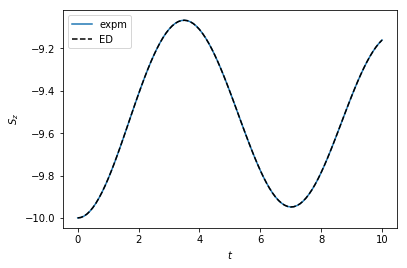

In [52]:
plt.plot(tvec,observables[0])
plt.plot(tvec,observables2[0],'k--')
plt.xlabel('$t$')
plt.ylabel('$S_z$')
plt.legend(('expm','ED'))
plt.show()

### Exercise 5

Study the long-time limit systematically as a function of $\Omega$. Loop $\Omega$ from 0 to 1 in at least 50 steps. Use at least N=100. Calculate the values of $S_z$ and $S_z^2$ at some long time. Also calculate the infinite time average 
$$
\langle O \rangle_\infty = \sum_k |\langle \psi_0|\phi_k\rangle|^2 \langle \phi_k|O|\phi_k\rangle
$$
Compare your results to Fig. 6 in https://arxiv.org/abs/1708.01044. This shows the dynmaical phase transition.

In [15]:
N = 400
dim = N+1
tlong = 100
ini = np.eye(1,dim,0)[0]

# loop over omega
omevec = np.linspace(0,1,50)
observables = 1j*np.zeros((4,len(omevec)))

for i in range(len(omevec)):
    # build the Hamiltonian and observables
    Sz = buildSz(N)
    Sz2 = Sz @ Sz
    Hmat =buildH(N,omevec[i])
    # diagonalize
    evals, evecs = LA.eigh(Hmat.toarray())
    # calculate projections on eigenstates
    iniProj = evecs.conj().T @ ini
    # calculate values at long time
    Psit = evecs @ (np.exp(-1j*evals*tlong)*iniProj)
    Szval = Psit.conj().T @ Sz @ Psit
    Sz2val = Psit.conj().T @ Sz2 @ Psit
    # calculate infinite time average of observables
    SzdiagEls = [evecs[:,k].conj().T @ Sz @ evecs[:,k] for k in range(dim)]
    Sz2diagEls = [evecs[:,k].conj().T @ Sz2 @ evecs[:,k] for k in range(dim)]
    Szinf = np.sum(SzdiagEls*abs(iniProj)**2)
    Sz2inf = np.sum(Sz2diagEls*abs(iniProj)**2)
    
    observables[:,i] = [Szval, Sz2val, Szinf, Sz2inf]



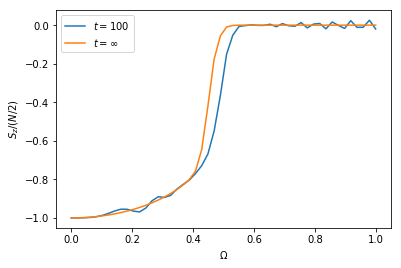

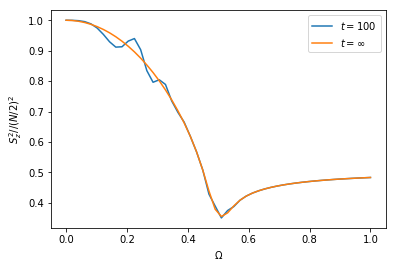

In [18]:
observables=observables.real

plt.plot(omevec,observables[0]/(N/2))
plt.plot(omevec,observables[2]/(N/2))
plt.xlabel('$\Omega$')
plt.ylabel('$S_z/(N/2)$')
plt.legend(('$t=100$','$t=\infty$'))
plt.show()
plt.plot(omevec,observables[1]/(N/2)**2)
plt.plot(omevec,observables[3]/(N/2)**2)
plt.xlabel('$\Omega$')
plt.ylabel('$S_z^2//(N/2)^2$')
plt.legend(('$t=100$','$t=\infty$'))
plt.show()

